In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PrepareData import prepare_dataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../seal_wrapper/')
from seal_wrapper import EA

## Prepare dataset

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset()
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = y_scaler.transform(y_val.values.reshape(-1, 1))

/home/simon/Dissertation/Abalone/PrepareData.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_test[['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']])
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardSc

In [3]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3383, 10) (3383, 1)
(376, 10) (376, 1)
(418, 10) (418,)


In [4]:
def plot_predictions(pred, y, save_as=None):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.plot(np.arange(0, 30, 0.1), np.arange(0, 30, 0.1))
    if save_as != None:
        plt.savefig(save_as)

In [5]:
def msse(pred, y):
    return np.sum((y-pred)**2) / y.shape[0]

In [6]:
def normalize_weights(w, var, gamma):
    return w * gamma / np.sqrt(var + 0.0001)

In [7]:
def normalize_bias(b, mean, var, beta, gamma):
    return (b - mean) * (gamma / np.sqrt(var + 0.0001)) + beta

In [8]:
X_test_enc = EA(X_test.values, True)

## Sigmoid model - BN with no shift or scale

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [9]:
sig_weights = np.load('model_sig_bn_weights.npy')

In [10]:
w1, b1, mean, std, w2, b2 = sig_weights

In [11]:
# no shifting or scaling
w_norm = normalize_weights(w1, std**2, 1)
b_norm = normalize_bias(b1, mean, std**2, 0, 1)

In [12]:
X_test_enc = EA(X_test.values, True)

In [13]:
w_norm_enc = EA(w_norm)
b_norm_enc = EA(b_norm.reshape(1, -1))
w2_enc = EA(w2)
b2_enc = EA(b2.reshape(1, -1))

In [14]:
layer1 = X_test_enc.dot(w_norm_enc) + b_norm_enc
layer1_sig = layer1.activate_sigmoid()
pred_sig = layer1_sig.dot(w2_enc) + b2_enc

In [15]:
sse_sig_enc = sum_squared_error(pred_sig.values().flatten(), y_test)
print('SSE sigmoid enc: {}'.format(sse_sig_enc))

SSE sigmoid enc: 255939.91026293565


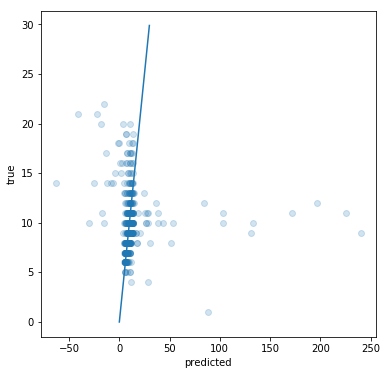

In [16]:
plot_predictions(pred_sig.values().reshape(-1,), y_test, save_as='enc_sig_bn.png')

In [17]:
layer1_clear = X_test.values.dot(w_norm) + b_norm
layer1_sig_clear = sigmoid(layer1_clear)
pred_sig_clear = layer1_sig_clear.dot(w2) + b2

In [18]:
sse_sig_clear = sum_squared_error(pred_sig_clear.flatten(), y_test)
print('SSE sigmoid clear: {}'.format(sse_sig_clear))

SSE sigmoid clear: 2735.403016694569


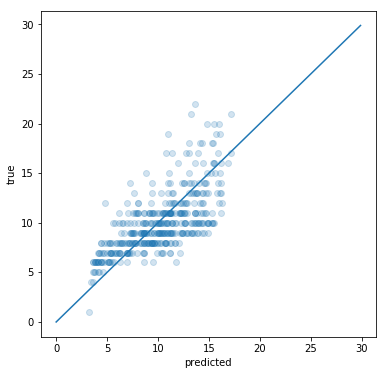

In [19]:
plot_predictions(pred_sig_clear.flatten(), y_test, save_as='clear_sig_bn.png')

## Sigmoid Model - BN

In [31]:
sig_weights = np.load('sig_bn_shift_weights.npy')

In [32]:
w1, b1, scale, shift, mean, std, w2, b2 = sig_weights

In [33]:
w_norm = normalize_weights(w1, std**2, scale)
b_norm = normalize_bias(b1, mean, std**2, shift, scale)

In [34]:
w_norm_enc = EA(w_norm)
b_norm_enc = EA(b_norm.reshape(1, -1))
w2_enc = EA(w2)
b2_enc = EA(b2.reshape(1, -1))

In [35]:
layer1 = X_test_enc.dot(w_norm_enc) + b_norm_enc
layer1_sig = layer1.activate_sigmoid()
pred_sig = layer1_sig.dot(w2_enc) + b2_enc

In [36]:
sse_sig_enc = sum_squared_error(pred_sig.values().flatten(), y_test)
print('SSE sigmoid enc: {}'.format(sse_sig_enc))

SSE sigmoid enc: 141393440.01186663


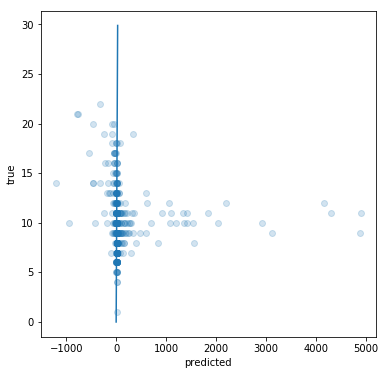

In [44]:
plot_predictions(pred_sig.values().reshape(-1,), y_test, save_as='enc_sig_bn_full.png')

In [38]:
layer1_clear = X_test.values.dot(w_norm) + b_norm
layer1_sig_clear = sigmoid(layer1_clear)
pred_sig_clear = layer1_sig_clear.dot(w2) + b2

In [39]:
sse_sig_clear = sum_squared_error(pred_sig_clear.flatten(), y_test)
print('SSE sigmoid clear: {}'.format(sse_sig_clear))

SSE sigmoid clear: 2469.697035480219


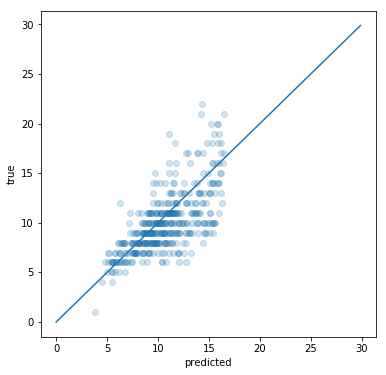

In [45]:
plot_predictions(pred_sig_clear.flatten(), y_test, save_as='clear_sig_bn_full.png')

## Relu

In [9]:
def relu(z):
    return np.maximum(z, 0)

In [10]:
relu_weights = np.load('relu_weights.npy')

In [11]:
#w1, b1, gamma, beta, mean, var, w2, b2 = relu_weights

In [12]:
w1, b1, w2, b2 = relu_weights

In [13]:
# w_norm = normalize_weights(w1, var**2, gamma)
# b_norm = normalize_bias(b1, mean, var**2, beta, gamma).reshape(1, -1)

In [14]:
# layer1 = X_test_enc.dot(EA(w_norm)) + EA(b_norm.reshape(1, -1))
# layer1_relu = layer1.relu()
# pred_relu = layer1_relu.dot(EA(w2)) + EA(b2.reshape(1, -1))

In [15]:
layer1 = X_test_enc.dot(EA(w1)) + EA(b1.reshape(1, -1))
layer1_relu = layer1.relu()
pred_relu = layer1_relu.dot(EA(w2)) + EA(b2.reshape(1, -1))

In [16]:
layer1_clear = X_test.values.dot(w1) + b1
print(layer1_clear.mean(axis=0), layer1_clear.std(axis=0), layer1_clear.max(), layer1_clear.min())
layer1_relu_clear = relu(layer1_clear)
pred_relu_clear = layer1_relu_clear.dot(w2) + b2

[0.06529055 0.97552659] [0.22328758 0.35462356] 1.8461759211554782 -0.8194880085497782


In [17]:
pred_relu = y_scaler.inverse_transform(pred_relu.values().flatten())
pred_relu_clear = y_scaler.inverse_transform(pred_relu_clear.flatten())

In [18]:
msse_relu_enc = msse(pred_relu, y_test)
print('MSSE relu enc: {}'.format(msse_relu_enc))

MSSE relu enc: 6.258569503665151


In [19]:
msse_relu_clear = msse(pred_relu_clear, y_test)
print('MSSE relu clear: {}'.format(msse_relu_clear))

MSSE relu clear: 4.4122892809742424


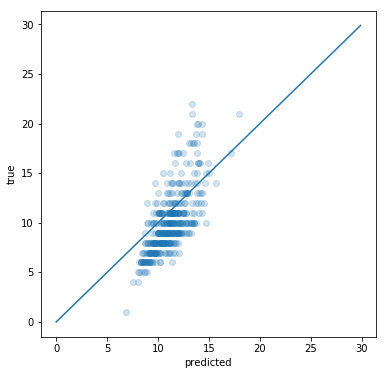

In [20]:
plot_predictions(pred_relu, y_test)

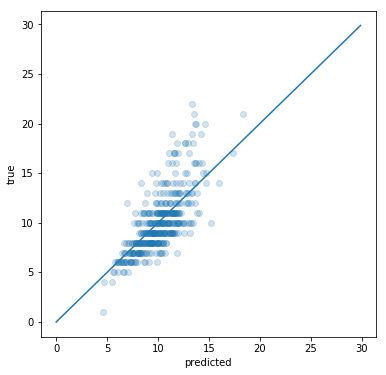

In [21]:
plot_predictions(pred_relu_clear.flatten(), y_test)